<a href="https://colab.research.google.com/github/felippe-trigueiro/Data_Science/blob/master/Covid_Analysis_Digio_Felippe_Trigueiro_Angelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análise dos Dados da Covid19**

**Autor:** Felippe Trigueiro Angelo

**Email:** trigueiro.angelo@outlook.com



## **Introdução**

Será feita uma análise sobre os dados da Covid19 utilizando o dataset fornecido pelo data.world e que está disponível [neste link](https://data.world/covid-19-data-resource-hub/covid-19-case-counts). Esses dados correspondem a um conjunto de séries temporais correspondentes aos números de casos e mortes em vários países do mundo. Os dados foram obtidos do The New York Times, the European Centre for Disease Prevention and Control e Public Health Agency of Canada.

In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.optimize import curve_fit

Primeiramente os arquivos referentes as bases de dados serão carregados em um DataFrame.

In [129]:
covid_activity_path = '/content/Covid_Dataset/COVID-19 Activity.csv'
covid_cases_path = '/content/Covid_Dataset/COVID-19 Cases.csv'

covid_activity_dataset = pd.read_csv(covid_activity_path)
covid_cases_dataset = pd.read_csv(covid_cases_path)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## **Análise inicial dos dados fornecidos**

Foram fornecidos duas tabelas, a COVID-19 activity e a COVID-19 cases. Vamos analisar inicialmente a tabela Covid Cases.

### **Covid cases**

In [130]:
covid_cases_dataset.head()

,Case_Type,People_Total_Tested_Count,Cases,Difference,Date,Combined_Key,Country_Region,Province_State,Admin2,iso2,iso3,FIPS,Lat,Long,Population_Count,People_Hospitalized_Cumulative_Count,Data_Source,Prep_Flow_Runtime
0,Confirmed,NaN,6,0,5/22/2020,Western Sahara,Western Sahara,NaN,NaN,EH,ESH,NaN,24.215500,-12.885800,597330.0,NaN,2019 Novel Coronavirus COVID-19 (2019-nCoV) Da...,6/4/2020 11:15:39 PM
1,Confirmed,NaN,0,0,2/3/2020,Switzerland,Switzerland,NaN,NaN,CH,CHE,NaN,46.818200,8.227500,8654618.0,NaN,2019 Novel Coronavirus COVID-19 (2019-nCoV) Da...,6/4/2020 11:15:39 PM
2,Deaths,NaN,0,0,3/1/2020,Cyprus,Cyprus,NaN,NaN,CY,CYP,NaN,35.126400,33.429900,1207361.0,NaN,2019 Novel Coronavirus COVID-19 (2019-nCoV) Da...,6/4/2020 11:15:39 PM
3,Confirmed,NaN,23,0,4/21/2020,Antigua and Barbuda,Antigua and Barbuda,NaN,NaN,AG,ATG,NaN,17.060800,-61.796400,97928.0,NaN,2019 Novel Coronavirus COVID-19 (2019-nCoV) Da...,6/4/2020 11:15:39 PM
4,Deaths,NaN,56,0,5/11/2020,Thailand,Thailand,NaN,NaN,TH,THA,NaN,15.870032,100.992541,69799978.0,NaN,2019 Novel Coronavirus COVID-19 (2019-nCoV) Da...,6/4/2020 11:15:39 PM


In [131]:
covid_cases_dataset.shape

(950670, 18)

In [132]:
covid_cases_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 950670 entries, 0 to 950669
Data columns (total 18 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Case_Type                             950670 non-null  object 
 1   People_Total_Tested_Count             6048 non-null    float64
 2   Cases                                 950670 non-null  int64  
 3   Difference                            950670 non-null  int64  
 4   Date                                  950670 non-null  object 
 5   Combined_Key                          950670 non-null  object 
 6   Country_Region                        950670 non-null  object 
 7   Province_State                        901260 non-null  object 
 8   Admin2                                878580 non-null  object 
 9   iso2                                  949590 non-null  object 
 10  iso3                                  949860 non-null  object 
 11  

In [133]:
#As features que possuem dados faltantes são colocadas como True, o restante como False.
covid_cases_have_misvalue = covid_cases_dataset.isna().sum() > 0
covid_cases_features_misvalue = list(covid_cases_dataset.iloc[:, covid_cases_have_misvalue.values].columns)
covid_cases_features_misvalue

['People_Total_Tested_Count',
 'Province_State',
 'Admin2',
 'iso2',
 'iso3',
 'FIPS',
 'Lat',
 'Long',
 'Population_Count',
 'People_Hospitalized_Cumulative_Count']

In [134]:
covid_cases_dataset.Date = pd.to_datetime(covid_cases_dataset.Date)

covid_cases_first_date = np.unique(covid_cases_dataset['Date'].sort_values(ascending=True))[0]
covid_cases_last_date = np.unique(covid_cases_dataset['Date'].sort_values(ascending=True))[-1]

print("Primeira data de coleta dos dados no Dataset Covid_Cases (Formato M/D/A): " + str(covid_cases_first_date))
print("Última data de coleta dos dados no Dataset Covid_Cases (Formato M/D/A): " + str(covid_cases_last_date))

Primeira data de coleta dos dados no Dataset Covid_Cases (Formato M/D/A): 2020-01-22T00:00:00.000000000
Última data de coleta dos dados no Dataset Covid_Cases (Formato M/D/A): 2020-06-04T00:00:00.000000000


In [135]:
covid_cases_dataset.sort_values('Date', inplace=True, ascending=True)

#### **Comentários**

A partir da análise dos comandos acima podemos constatar algumas informações importantes:

1. A tabela contém 18 features e 950670 registros de entrada;
2. Existem 10 features contém dados faltantes. São elas:
  *   People_Total_Tested_Count
  *   Province_State
  *   Admin2
  *   iso2
  *   iso3
  *   FIPS
  *   Lat
  *   Long
  *   Population_Count
  *   People_Hospitalized_Cumulative_Count
3. Segundo a [descrição das Features](https://data.world/covid-19-data-resource-hub/covid-19-case-counts/workspace/data-dictionary), as Features admin2 e fips estão disponíveis apenas para os municípios dos Estados Unidos. A Feature province_state está disponíível apenas para Australia, Canadá, China, Dinamarca, França, Holanda, Reino Unido e Estados Unidos;
4. Existem 4 Features que representam informações similares, neste caso o país. Assim todas essas Features podem ser substituídas apenas por uma delas. As Features em questão são:
  *    Combined_Key
  *    Country_Region
  *    iso2
  *    iso3
5. As data em que os dados foram coletados está compreendida entre 22/1/2020 e 4/6/2020 (Formato Brasileiro).


### **Covid Activity**

Nesta seção serão apresentadas informações gerais sobre essa tabela, com a finalidade de entender informações como:

1. A forma como os dados estão estruturados;
2. Número de entradas da tabela;
3. Quantidade de Features da tabela;
4. Quantidade de dados faltantes da tabela.

Para uma descrição detalhada do significado de cada uma das features, favor visitar [a página do data.world](https://data.world/covid-19-data-resource-hub/covid-19-case-counts/workspace/data-dictionary). Entretanto, ao longo deste notebook, as features mais importantes serão descritas com mais detalhes.

In [136]:
covid_activity_dataset.head()

,COUNTY_NAME,COUNTY_FIPS_NUMBER,PEOPLE_POSITIVE_CASES_COUNT,REPORT_DATE,PROVINCE_STATE_NAME,CONTINENT_NAME,DATA_SOURCE_NAME,PEOPLE_DEATH_NEW_COUNT,COUNTRY_ALPHA_3_CODE,COUNTRY_SHORT_NAME,COUNTRY_ALPHA_2_CODE,PEOPLE_POSITIVE_NEW_CASES_COUNT,PEOPLE_DEATH_COUNT
0,NaN,NaN,684,6/16/2020,Saskatchewan,America,Public Health Agency of Canada,0,CAN,Canada,CA,1,13
1,NaN,NaN,19,3/12/2020,Alberta,America,Public Health Agency of Canada,0,CAN,Canada,CA,5,0
2,NaN,NaN,13,4/28/2020,Repatriated travellers,America,Public Health Agency of Canada,0,CAN,Canada,CA,0,0
3,NaN,NaN,7482,6/16/2020,Alberta,America,Public Health Agency of Canada,0,CAN,Canada,CA,29,151
4,NaN,NaN,221,3/22/2020,Quebec,America,Public Health Agency of Canada,0,CAN,Canada,CA,19,4


In [137]:
covid_activity_dataset.shape

(488986, 13)

In [138]:
covid_activity_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 488986 entries, 0 to 488985
Data columns (total 13 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   COUNTY_NAME                      452880 non-null  object 
 1   COUNTY_FIPS_NUMBER               445776 non-null  float64
 2   PEOPLE_POSITIVE_CASES_COUNT      488986 non-null  int64  
 3   REPORT_DATE                      488986 non-null  object 
 4   PROVINCE_STATE_NAME              454476 non-null  object 
 5   CONTINENT_NAME                   488986 non-null  object 
 6   DATA_SOURCE_NAME                 488986 non-null  object 
 7   PEOPLE_DEATH_NEW_COUNT           488986 non-null  int64  
 8   COUNTRY_ALPHA_3_CODE             488986 non-null  object 
 9   COUNTRY_SHORT_NAME               488986 non-null  object 
 10  COUNTRY_ALPHA_2_CODE             488816 non-null  object 
 11  PEOPLE_POSITIVE_NEW_CASES_COUNT  488986 non-null  int64  
 12  PE

In [139]:
#As features que possuem dados faltantes são colocadas como True, o restante como False.
covid_activity_have_misvalue = covid_activity_dataset.isna().sum() > 0
covid_activity_features_misvalue = list(covid_activity_dataset.iloc[:, covid_activity_have_misvalue.values].columns)
covid_activity_features_misvalue

['COUNTY_NAME',
 'COUNTY_FIPS_NUMBER',
 'PROVINCE_STATE_NAME',
 'COUNTRY_ALPHA_2_CODE']

In [140]:
covid_activity_dataset.REPORT_DATE = pd.to_datetime(covid_activity_dataset.REPORT_DATE)

covid_activity_first_date = np.unique(covid_activity_dataset['REPORT_DATE'].sort_values(ascending=True))[0]
covid_activity_last_date = np.unique(covid_activity_dataset['REPORT_DATE'].sort_values(ascending=True))[-1]

print("Primeira data de coleta dos dados no Dataset Covid_Cases (Formato M/D/A): " + str(covid_activity_first_date))
print("Última data de coleta dos dados no Dataset Covid_Cases (Formato M/D/A): " + str(covid_activity_last_date))

Primeira data de coleta dos dados no Dataset Covid_Cases (Formato M/D/A): 2019-12-31T00:00:00.000000000
Última data de coleta dos dados no Dataset Covid_Cases (Formato M/D/A): 2020-06-17T00:00:00.000000000


In [141]:
covid_activity_dataset.sort_values('REPORT_DATE', inplace=True, ascending=True)

#### **Comentários**

A partir da análise dos comandos acima podemos constatar algumas informações importantes:

1. A tabela contém 13 features e 471028 registros de entrada;
2. Existem 4 features contém dados faltantes. São elas:
  *   County_name
  *   County_Fips_Number
  *   Province_State_Name
  *   Country_Alpha_2_Code
3. Segundo a [descrição das Features](https://data.world/covid-19-data-resource-hub/covid-19-case-counts/workspace/data-dictionary), as Features County_Name e County_Fips_Number estão disponíveis apenas para os municípios dos Estados Unidos.
4. Existem 3 Features que representam a mesma informação, neste caso o país. Assim 2 dessas features serão possivelmente eliminadas, com a finalidade de se realizar uma vizualização mais limpa. As Features em questão são:
  *    Country_Alpha_2_Code
  *    Country_Alpha_3_Code
  *    Country_Short_Name
5. As data em que os dados foram coletados está compreendida entre 1/1/2020 e 17/6/2020 (Formato Brasileiro).


## **Análise da Covid no Brasil**

A partir desta seção serão feitas algumas análises do cenário da Covid 19 no Brasil. Assim, algumas perguntas buscarão ser respondidas. São elas:
1. Como comparar o Brasil com outros países? Qual métrica utilizar?
2. Qual seria o cenário da Covid em nosso país caso as medidas de isolamento não tivessem sido tomadas? Quais métodos devem ser utilizados?
3. Qual seráo cenário da Covid no Brasil daqui a 30 dias? E daqui a 6 meses 

### **Pré-Processamento dos Dados**

In [142]:
Covid_Activity_Brazil = covid_activity_dataset.iloc[(covid_activity_dataset.COUNTRY_SHORT_NAME == 'Brazil').values, :]
Covid_Activity_Brazil.sort_values('REPORT_DATE', ascending=True).head()

,COUNTY_NAME,COUNTY_FIPS_NUMBER,PEOPLE_POSITIVE_CASES_COUNT,REPORT_DATE,PROVINCE_STATE_NAME,CONTINENT_NAME,DATA_SOURCE_NAME,PEOPLE_DEATH_NEW_COUNT,COUNTRY_ALPHA_3_CODE,COUNTRY_SHORT_NAME,COUNTRY_ALPHA_2_CODE,PEOPLE_POSITIVE_NEW_CASES_COUNT,PEOPLE_DEATH_COUNT
430359,NaN,NaN,0,2019-12-31,NaN,America,European Centre for Disease Prevention and Con...,0,BRA,Brazil,BR,0,0
445068,NaN,NaN,0,2020-01-01,NaN,America,European Centre for Disease Prevention and Con...,0,BRA,Brazil,BR,0,0
451799,NaN,NaN,0,2020-01-02,NaN,America,European Centre for Disease Prevention and Con...,0,BRA,Brazil,BR,0,0
433027,NaN,NaN,0,2020-01-03,NaN,America,European Centre for Disease Prevention and Con...,0,BRA,Brazil,BR,0,0
468047,NaN,NaN,0,2020-01-04,NaN,America,European Centre for Disease Prevention and Con...,0,BRA,Brazil,BR,0,0


Uma medida interessante consiste em retirar algumas Features para obter assim um DataFrame mais enxuto. Features como COUNTY_NAME, COUNTY_FIPS_NUMBER e PROVINCE_STATE_NAME que não contém informação sobre o Brazil, serão retiradas. Features como CONTINENT_NAME, COUNTRY_ALPHA_3_CODE, COUNTRY_SHORT_NAME e COUNTRY_ALPHA_2_CODE não trazem informações relevantes para a nossa anáálise e também serão retiradas.

In [143]:
drop_features = ['COUNTY_NAME', 'COUNTY_FIPS_NUMBER', 'PROVINCE_STATE_NAME', 'CONTINENT_NAME', 
                 'COUNTRY_ALPHA_3_CODE', 'COUNTRY_SHORT_NAME', 'COUNTRY_ALPHA_2_CODE']
Covid_Activity_Brazil.drop(columns=drop_features, inplace=True)
Covid_Activity_Brazil.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,PEOPLE_POSITIVE_CASES_COUNT,REPORT_DATE,DATA_SOURCE_NAME,PEOPLE_DEATH_NEW_COUNT,PEOPLE_POSITIVE_NEW_CASES_COUNT,PEOPLE_DEATH_COUNT
430359,0,2019-12-31,European Centre for Disease Prevention and Con...,0,0,0
445068,0,2020-01-01,European Centre for Disease Prevention and Con...,0,0,0
451799,0,2020-01-02,European Centre for Disease Prevention and Con...,0,0,0
433027,0,2020-01-03,European Centre for Disease Prevention and Con...,0,0,0
468047,0,2020-01-04,European Centre for Disease Prevention and Con...,0,0,0


In [144]:
np.unique(Covid_Activity_Brazil.DATA_SOURCE_NAME)

array(['European Centre for Disease Prevention and Control'], dtype=object)

Como os dados brasileiros vem apenas do European Centre for Disease Prevention and Control, a feature DATA_SOURCE_NAME também será retirada.

In [145]:
Covid_Activity_Brazil.drop(columns=['DATA_SOURCE_NAME'], inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Antes de serem realizadas algumas análises sobre a situação do Covid 19 no Brasil, é importante saber qual base de dados usar: Covid_Activity ou Covid_Cases?

Segundo a [descrição](https://data.world/covid-19-data-resource-hub/covid-19-case-counts) das bases de dados, a base Covid_Cases deixou de ser atualizada em 5/6/2020, além de que a base Covid_Activity possui organização melhor, como descrito [neste artigo](https://www.tableau.com/about/blog/2020/5/8-changes-to-covid-19-data-set) publicado no site do Tableu.

Porém, como vimos nas seções anteriores, a Base Covid_Cases possui duas Features interessantes para a análise da doença: People_Hospitalized_Cumulative_Count e People_Total_Tested_Count, porém estes dados estão disponíveis apenas para os Estados Unidos, como pode ser visto no código abaixo.

Portanto, dadas as vantagens da base Covid_Activity, usaremos ela para as análises que serão realizadas posteriormente.

In [146]:
#Foi selecionado os dados do covid referentes ao Brasil
covid_cases_brasil = covid_cases_dataset.iloc[(covid_cases_dataset.Combined_Key == 'Brazil').values, :]

#Foram selecionadas as Features People_Hospitalized_Cumulative_Count e  People_Total_Tested_Count;
#Foram verificados os valores únicos que existiam nessas features. Após isso, foi verificado se todos os valores
#retornados era nan. O valor 1 indica que todos eram 1;
np.prod(np.isnan(np.unique(covid_cases_brasil[['People_Hospitalized_Cumulative_Count', 'People_Total_Tested_Count']])))

1

## **Evolução do número de casos no Brasil**

In [147]:
Covid_Activity_Brazil.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170 entries, 430359 to 485356
Data columns (total 5 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   PEOPLE_POSITIVE_CASES_COUNT      170 non-null    int64         
 1   REPORT_DATE                      170 non-null    datetime64[ns]
 2   PEOPLE_DEATH_NEW_COUNT           170 non-null    int64         
 3   PEOPLE_POSITIVE_NEW_CASES_COUNT  170 non-null    int64         
 4   PEOPLE_DEATH_COUNT               170 non-null    int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 8.0 KB


Aqui vemos que não temos nenhum dado faltante em nossa base de dados do Brasil. Assim, não precisaremos aplicar nenhuma técnica para reposição dos dados.

In [148]:
Covid_Activity_Brazil = Covid_Activity_Brazil.set_index('REPORT_DATE')

In [149]:
monday_2020 = np.arange(datetime(2020,1,6), datetime(2020,6,20), timedelta(days=7))
Covid_Activity_Brazil_monday = Covid_Activity_Brazil.loc[monday_2020]

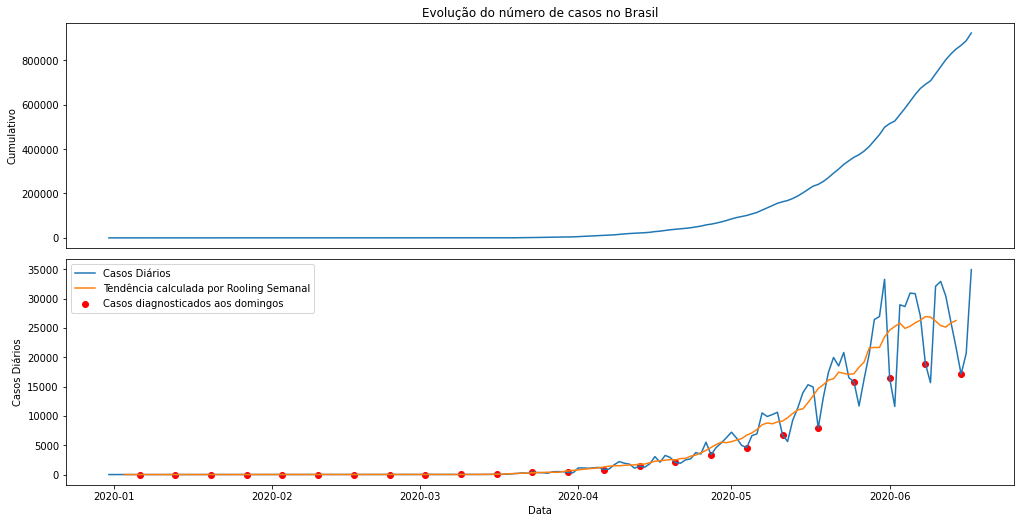

In [150]:
plt.figure(figsize=(17, 8.5))
plt.subplots_adjust(hspace=0.05, wspace=0.115)

#Casos Totais
plt.subplot(211)
_=plt.title('Evolução do número de casos no Brasil')
plt.plot(Covid_Activity_Brazil.index, Covid_Activity_Brazil.PEOPLE_POSITIVE_CASES_COUNT)
plt.xticks([])
_=plt.ylabel('Cumulativo')


#Casos Diários
plt.subplot(212)
plt.plot(Covid_Activity_Brazil.index, Covid_Activity_Brazil.PEOPLE_POSITIVE_NEW_CASES_COUNT, label='Casos Diários')
#Calculando a tendência para os casos diários de covid
covid_activity_weekly_rooling = Covid_Activity_Brazil['PEOPLE_POSITIVE_NEW_CASES_COUNT'].rolling(window = 7, center = True).mean()
plt.plot(covid_activity_weekly_rooling, label='Tendência calculada por Rooling Semanal')
plt.scatter(Covid_Activity_Brazil_monday.index, Covid_Activity_Brazil_monday.PEOPLE_POSITIVE_NEW_CASES_COUNT, c='red', label='Casos diagnosticados aos domingos')
plt.legend()
_=plt.xlabel('Data')
_=plt.ylabel('Casos Diários')

In [151]:
first_case_Brazil = Covid_Activity_Brazil.iloc[(Covid_Activity_Brazil.PEOPLE_POSITIVE_CASES_COUNT==1).values, :]

print("Primeiro Caso de Covid: " + str(first_case_Brazil.index[0].date()))

Primeiro Caso de Covid: 2020-02-26


In [152]:
total_number_cases = Covid_Activity_Brazil.PEOPLE_POSITIVE_CASES_COUNT.sort_values(ascending=False)
print("Número total de casos no Brasil (17/6/2020): " + str(total_number_cases[0]))

Número total de casos no Brasil (17/6/2020): 923189


In [153]:
maximum_number_cases = np.amax(Covid_Activity_Brazil.PEOPLE_POSITIVE_NEW_CASES_COUNT)
date_maximum_case_Brazil = Covid_Activity_Brazil.iloc[(Covid_Activity_Brazil.PEOPLE_POSITIVE_NEW_CASES_COUNT==maximum_number_cases).values, :].index
print("O número máximo de casos diários no Brasil foi de " + str(maximum_number_cases) + " e ocorreu em " + 
      str(date_maximum_case_Brazil[0].date()))

O número máximo de casos diários no Brasil foi de 34918 e ocorreu em 2020-06-17


## **Evolução do número de mortes no Brasil**

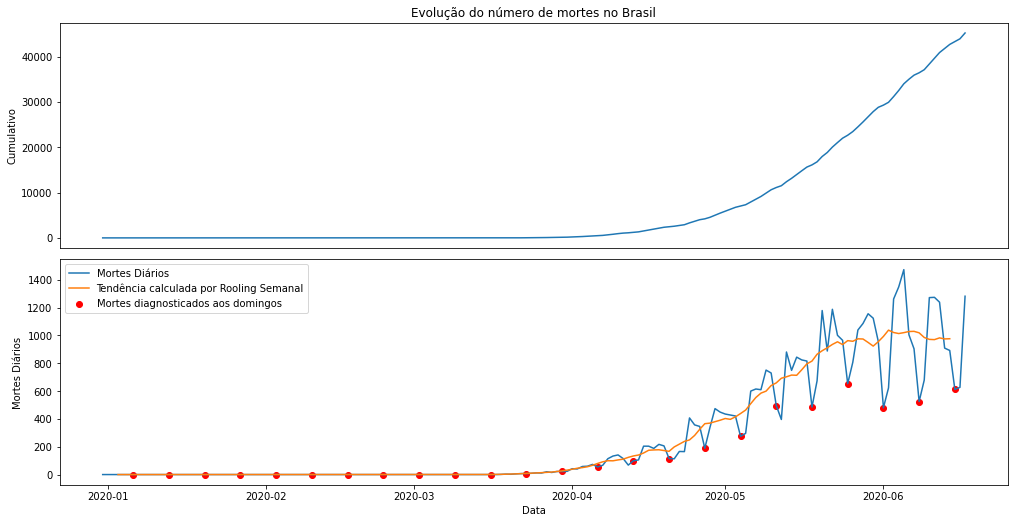

In [154]:
plt.figure(figsize=(17, 8.5))
plt.subplots_adjust(hspace=0.05, wspace=0.115)

#Mortes Totais
plt.subplot(211)
_=plt.title('Evolução do número de mortes no Brasil')
plt.plot(Covid_Activity_Brazil.index, Covid_Activity_Brazil.PEOPLE_DEATH_COUNT)
plt.xticks([])
_=plt.ylabel('Cumulativo')

#Mortes Diárias
plt.subplot(212)
plt.plot(Covid_Activity_Brazil.index, Covid_Activity_Brazil.PEOPLE_DEATH_NEW_COUNT, label='Mortes Diários')
#Calculando a tendência para os casos diários de covid
covid_activity_weekly_rooling = Covid_Activity_Brazil['PEOPLE_DEATH_NEW_COUNT'].rolling(window = 7, center = True).mean()
plt.plot(covid_activity_weekly_rooling, label='Tendência calculada por Rooling Semanal')
plt.scatter(Covid_Activity_Brazil_monday.index, Covid_Activity_Brazil_monday.PEOPLE_DEATH_NEW_COUNT, c='red', label='Mortes diagnosticados aos domingos')
plt.legend()
_=plt.xlabel('Data')
_=plt.ylabel('Mortes Diários')

In [155]:
first_death_Brazil = Covid_Activity_Brazil.iloc[(Covid_Activity_Brazil.PEOPLE_DEATH_COUNT==1).values, :]

print("Primeira Morte de Covid: " + str(first_death_Brazil.index[0].date()))

Primeira Morte de Covid: 2020-03-18


In [156]:
total_number_deaths = Covid_Activity_Brazil.PEOPLE_DEATH_COUNT.sort_values(ascending=False)
print("Número total de mortes no Brasil (12/6/2020): " + str(total_number_deaths[0]))

Número total de mortes no Brasil (12/6/2020): 45241


In [157]:
maximum_number_deaths = np.amax(Covid_Activity_Brazil.PEOPLE_DEATH_NEW_COUNT)
date_maximum_death_Brazil = Covid_Activity_Brazil.iloc[(Covid_Activity_Brazil.PEOPLE_DEATH_NEW_COUNT==maximum_number_deaths).values, :].index
print("O número máximo de mortes diárias no Brasil foi de " + str(maximum_number_deaths) + " e ocorreu em " + 
      str(date_maximum_death_Brazil[0].date()))

O número máximo de mortes diárias no Brasil foi de 1473 e ocorreu em 2020-06-05


#### **Comentários**

A partir das informações e visualizações extraídas acima, é possível afirmar algumas coisas:
1. Até o dia (17/6/2020) tivemos 923189 casos e 45241 mortes decorrentes da Covid 19;
2. O primeiro caso da Covid 19 ocorreu em 2020-02-26, já a primeira morte em 2020-03-18;
3. O número máximo de casos diários no Brasil foi de 34918 e ocorreu em 2020-06-17, já o número máximo de mortes diárias no Brasil foi de 1473 e ocorreu em 2020-06-05.
4. Sobre a evolução da doença no país, podemos dizer que estamos passando pelo pico da curva tanto do número de casos como do número de mortes, o que indica que se continuadas as mesmas condições atuais, nas próximas semanas teremos uma diminuição do número diário desses indicadores, bem como uma diminuição da velocidade de crescimento do cumulativo dos mesmos.
5. Também é possível ver que existe uma oscilação periódica tanto no número de casos quanto no número de mortos. Esta oscilação ocorre na divulgação dos números às Segundas-Feiras, que corresponde aos dados dos Domingos, onde provavelmente temos um número menor de profissionais e materiais disponíveis para a realização e publicação dos testes.

## **Comparação do Brasil com outros países**

Em uma comparação de qualquer natureza se faz necessário um processamento dos dados para que todas as entradas estejam sendo representadas nas mesmas condições. Assim, para compararmos a situação da Covid19 no Brasil, deve-se utilizar de alguns critérios e aplicá-los de forma igual aos países que serão comparados. 

Para tal podemos utilizar os seguintes critérios:
1. Normalização dos dados pela população. Apesar de não eliminar totalmente as diferenças, o tamanho da população dos países é um importante indicador da **potencial** quantidade de casos e mortes, **dadas outras condições**. Para esta normalização utilizaremos os dados fornecidos pelo [Banco Mundial](https://data.worldbank.org/country/).
2. Utilizar uma comparação entre os casos após o primeiro caso. Para que tenhamos uma comparação mais precisa, é necessário que tenhamos uma escala de tempo similar para a pandemia em cada um dos países.

**Observações**

1. No critério 1, para uma avaliação mais precisa se faz necessária uma análise levando em consideração estruturas menores como estados e municípios, assim não levaríamos em conta somente a população total do país, mas também a densidade populacional por região. Tal critério se faz relevante devido ao fato de que mesmo em países grandes, a população pode estar concentrada em regiões pequenas. Assim, ao se observar apenas a densidade populacional total, teria-se a impressão de a densidade populacional é baixa, quando na verdade ela é o contrário. Entretanto, como a nossa base de dados fornece os dados do covid apenas para os estados e municípios americanos, iremos limitar a nossa comparação apenas a uma normalização da população do país.
2. Em ambos os critérios, para uma comparação mais justa, seria interessante levar em consideração uma normalização pela quantidade de testes, afinal, quanto mais testes realizados, maior a probabilidade de se detectar casos e mortes. Entretanto, devido a ausência destes dados, não iremos incluí-los em nossa comparação.  

In [158]:
population = {'Brazil':209469333, 'United States':326687501, 'United Kingdom':66460344, 'Italy':60421760, 'Spain':46796540, 
              'Germany':82905782, 'Argentina':44494502, 'Colombia':49648685, 'Chile':18792160}
population_df = pd.DataFrame(population, index=np.array([0]))

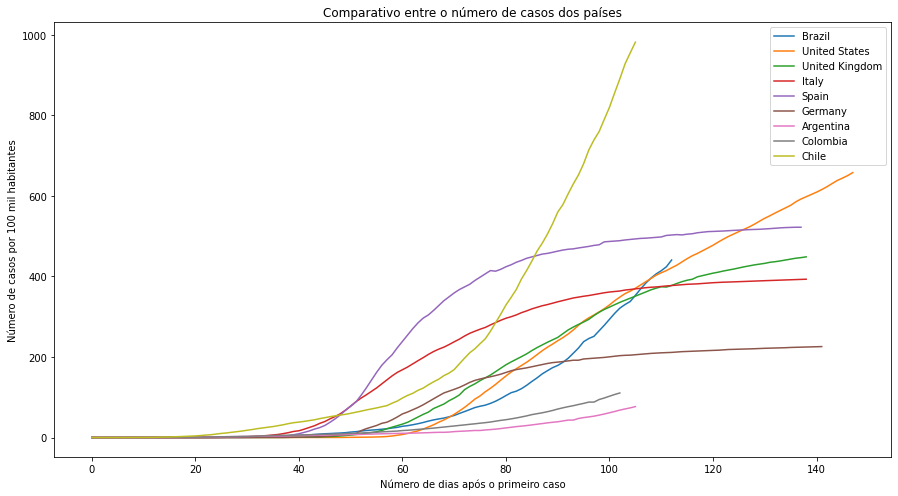

In [159]:
plt.figure(figsize=(15, 8))
for i in population_df.columns:
  country_df = covid_activity_dataset.iloc[(covid_activity_dataset.COUNTRY_SHORT_NAME==i).values, :]
  country_df = country_df.set_index('REPORT_DATE')
  first_case = country_df.iloc[(country_df.PEOPLE_POSITIVE_CASES_COUNT>=1).values, :]
  first_case = first_case.index.values[0]
  #days_2020 = np.arange(first_case, datetime(2020, 6, 13), timedelta(days=1))
  index_x = country_df.iloc[(country_df.index >= first_case), :].index.unique()
  x = np.arange(len(index_x))
  y = country_df.loc[index_x.values, 'PEOPLE_POSITIVE_CASES_COUNT']
  y = y.sort_index()
  y = (y.groupby(level=0).sum()/population_df[i].values)*100000
  
  plt.plot(x, y, label=i)
plt.legend()
_=plt.xlabel('Número de dias após o primeiro caso')
_=plt.ylabel('Número de casos por 100 mil habitantes')
_=plt.title('Comparativo entre o número de casos dos países')

**Comentários**

Nesta comparação de cenários da pandemia, foram comparados os seguintes países:
1. Alemanha 
2. Argentina
3. Brasil
4. Chile
5. Colômbia
6. Espanha
7. Estados Unidos
8. Itália
9. Reino Unido

A partir do gráfico acima, podemos constatar algumas coisas:
1. A partir dos dados fornecidos podemos ver que devido alguns países terem o primeiro caso da Covid 19 sendo diagnosticado mais tarde, a quantidade de dados difere entre eles;
2. Dentre as condições e os países utilizados na comparação é possível ver que o Chile é aquele que está na pior situação. Ao contrário do Chile, a Argentina encontra-se na melhor situação. Já o Brasil encontra-se na 4 colocação;
3.  Na comparação feita também é possível ver que 3 países já estão numa fase de estabilização do número de casos. São eles: Alemanha, Espanha e Itália.
4. O Brasil ainda não chegou nesta fase, porém pudemos ver nas análises anteriores, que dadas as condições atuais, o país deve começar a entrar nessa fase nas próximas semanas;

## **Criação de um modelo para predição do número de casos e de mortes**

Nesta seção iremos tentar criar um modelo que consiga predizer com um grau aceitável de acurácia o número de casos e de mortes decorrentes do Covid 19 no Brasil. Para tal, serão utilizados todos os dados disponíveis da pandemia em nosso país.

Antes de levantarmos hipóteses sobre como modelar esse fenômeno, temos que fazer algumas considerações:
1. Devido a nossa base de dados não ser completamente representativa do fenômeno real do Covid19, não podemos aplicar algoritmos de Machine Learning que não fazem nenhuma hipótese sobre os dados. Para aplicá-los se faz necessário um conjunto maior de features que representassem o fenômeno, tais como: Densidade demográfica por região e idade média da população. Assim, algoritmos como KNN, MLP e Random Forest estão descartados.
2. Dado o comportamento das curvas visto nas seções anteriores, podemos inferir que tanto que a curva do número de mortes quanto a curva do número de casos tem um comportamento similar ao de uma curva sigmoidal, assim curvas que tem esse comportamento podem ser utilizadas para modelagem.

Assim, utilizaremos as seguintes hipóteses para modelar o fenômeno:
1. Função Sigmóide;
2. Função Tangente Hiperbólico;

### **Previsão para o número de casos**

#### **Sigmóide**

In [160]:
def sigmoid(x, L, x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

In [161]:
X = np.arange(len(Covid_Activity_Brazil.index))
Y = Covid_Activity_Brazil.PEOPLE_POSITIVE_CASES_COUNT.values

In [162]:
constraints = [[1300000, len(X), 0, -np.inf], [2000000, len(X)+60, 1, np.inf]]
popt_sig_cases, pcov_sig_cases = curve_fit(sigmoid, X, Y, bounds=constraints)

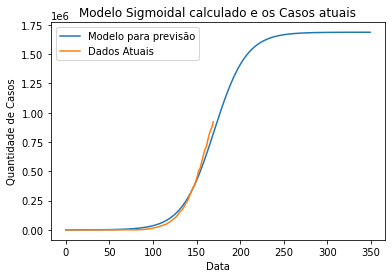

In [163]:
X_new = np.arange(len(X)+180)
plt.plot(X_new, sigmoid(X_new, *popt_sig_cases), label='Modelo para previsão')
plt.plot(X, Y, label='Dados Atuais')
plt.legend()
_=plt.ylabel('Quantidade de Casos')
_=plt.xlabel('Data')
_=plt.title('Modelo Sigmoidal calculado e os Casos atuais')

In [164]:
X_new = np.arange(len(X))
Y_model = sigmoid(X_new, *popt_sig_cases)

std_sig_cases = np.round(np.std(Y_model-Y))
print("O modelo Sigmoidal calculado tem uma precisão de mais ou menos " + str(np.round(std_sig_cases)) + " casos.")

O modelo Sigmoidal calculado tem uma precisão de mais ou menos 28908.0 casos.


#### **Tangente Hiperbólico**

In [165]:
def tanh(x, L ,x0, k, b):
    y = L*(np.exp(k*(x-x0))-np.exp(-k*(x-x0)))/ (np.exp(k*(x-x0)) + np.exp(-k*(x-x0)))+b
    return (y)

In [166]:
X = np.arange(len(Covid_Activity_Brazil.index))
Y = Covid_Activity_Brazil.PEOPLE_POSITIVE_CASES_COUNT.values

In [167]:
constraints = [[750000, len(X), 0, -np.inf], [2000000, len(X)+60, 1, np.inf]]
popt_tanh_cases, pcov_tanh_cases = curve_fit(tanh, X, Y, bounds=constraints)

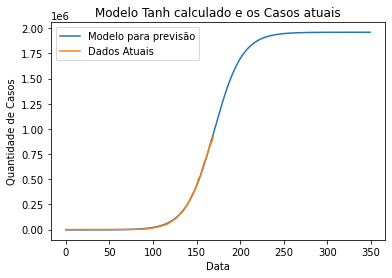

In [168]:
X_new = np.arange(len(X)+180)
plt.plot(X_new, tanh(X_new, *popt_tanh_cases), label='Modelo para previsão')
plt.plot(X, Y, label='Dados Atuais')
plt.legend()
_=plt.ylabel('Quantidade de Casos')
_=plt.xlabel('Data')
_=plt.title('Modelo Tanh calculado e os Casos atuais')

In [169]:
X_new = np.arange(len(X))
Y_model = tanh(X_new, *popt_tanh_cases)

#mse = np.sqrt((np.sum(np.square(Y_model - Y_actual)))/len(X_new))
std_tanh_cases = np.round(np.std(Y_model-Y))
print("O modelo Tanh calculado tem uma precisão de mais ou menos " + str(np.round(std_tanh_cases)) + " casos.")

O modelo Tanh calculado tem uma precisão de mais ou menos 6205.0 casos.


### **Previsão para o número de mortes**

#### **Sigmóide**

In [170]:
X = np.arange(len(Covid_Activity_Brazil.index))
Y = Covid_Activity_Brazil.PEOPLE_DEATH_COUNT.values

In [171]:
constraints = [[-250000, len(X), -1, -np.inf], [-68000, len(X)+60, 0, np.inf]]
popt_sig_deaths, pcov_sig_deaths = curve_fit(sigmoid, X, Y, bounds=constraints)

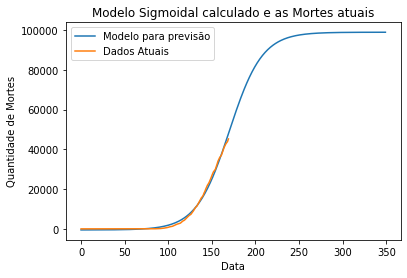

In [172]:
X_new = np.arange(len(X)+180)
plt.plot(X_new, sigmoid(X_new, *popt_sig_deaths), label='Modelo para previsão')
plt.plot(X, Covid_Activity_Brazil.PEOPLE_DEATH_COUNT, label='Dados Atuais')
plt.legend()
_=plt.ylabel('Quantidade de Mortes')
_=plt.xlabel('Data')
_=plt.title('Modelo Sigmoidal calculado e as Mortes atuais')

In [173]:
X_new = np.arange(len(Covid_Activity_Brazil.index))
Y_model = sigmoid(X_new, *popt_sig_deaths)
Y_actual = Covid_Activity_Brazil.PEOPLE_DEATH_COUNT

std_sig_deaths = np.round(np.std(Y_model-Y_actual))
print("O modelo Sigmoidal calculado tem uma precisão de mais ou menos " + str(np.round(std_sig_deaths)) + " mortes.")

O modelo Sigmoidal calculado tem uma precisão de mais ou menos 816.0 mortes.


#### **Tangente Hiperbólico**

In [174]:
X = np.arange(len(Covid_Activity_Brazil.index))
Y = Covid_Activity_Brazil.PEOPLE_DEATH_COUNT.values

In [175]:
constraints = [[20000, len(X), 0, 20000], [100000, len(X)+60, 1, 100000]]
popt_tanh_deaths, pcov_tanh_deaths = curve_fit(tanh, X, Y, bounds=constraints)

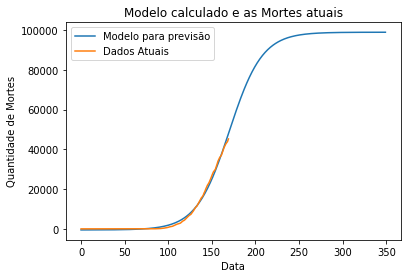

In [176]:
X_new = np.arange(len(X)+180)
plt.plot(X_new, tanh(X_new, *popt_tanh_deaths), label='Modelo para previsão')
plt.plot(X, Covid_Activity_Brazil.PEOPLE_DEATH_COUNT, label='Dados Atuais')
plt.legend()
_=plt.ylabel('Quantidade de Mortes')
_=plt.xlabel('Data')
_=plt.title('Modelo calculado e as Mortes atuais')

In [177]:
X_new = np.arange(len(Covid_Activity_Brazil.index))
Y_model = tanh(X_new, *popt_tanh_deaths)
Y_actual = Covid_Activity_Brazil.PEOPLE_DEATH_COUNT

std_tanh_deaths = np.round(np.std(Y_model-Y_actual))
print("O modelo Tanh calculado tem uma precisão de mais ou menos " + str(np.round(std_tanh_deaths)) + " mortes.")

O modelo Tanh calculado tem uma precisão de mais ou menos 816.0 mortes.


### **Conclusões destas predições**

Podemos ver que ambos os modelos performaram de maneira similar, entretanto, como os modelos utilizando função Sigmóide possuem o comportamento dos seus parâmetros mais bem definido, ou seja, a variação entre o formato da curva e a variação dos valores dos parâmetros são mais facilmente entendidos, eles serão utilizados para a predição do cenário da Covid daqui a 30 e 180 dias contados a partir do dia 10/6/2020.

Durante o fitting do modelo, codificamos as datas como sendo um array contendo as o número de dias desde 31/12/2019, que foi o primeiro dia encontrado na nossa base de dados. Assim o dia 31/12/2019 é codificado como 0, 1/1/2020 como 1, e assim por diante.

Como codificamos o dia 17/6/2020, como o tamanho do nosso array menos 1, tomaremos esta data como base para o nosso cálculo.

In [178]:
predict_cases_30 = np.round(sigmoid(len(X)-1-7+30, *popt_sig_cases))
predict_cases_180 = np.round(sigmoid(len(X)-1-7+180, *popt_sig_cases))
predict_deaths_30 = np.round(sigmoid(len(X)-1-7+30, *popt_sig_deaths))
predict_deaths_180 = np.round(sigmoid(len(X)-1-7+180, *popt_sig_deaths))

In [179]:
print('A previsão do número de casos para 30 dias é: ' + str(predict_cases_30) + ' variando ' + str(std_tanh_cases) + ' para mais ou para menos')
print('A previsão do número de mortes para 30 dias é: ' + str(predict_deaths_30) + ' variando ' + str(std_tanh_deaths) + ' para mais ou para menos')
print('A previsão do número de casos para 180 dias é: ' + str(predict_cases_180) + ' variando ' + str(std_tanh_cases) + ' para mais ou para menos')
print('A previsão do número de mortos para 180 dias é: ' + str(predict_deaths_180) + ' variando ' + str(std_tanh_deaths) + ' para mais ou para menos')

A previsão do número de casos para 30 dias é: 1295450.0 variando 6205.0 para mais ou para menos
A previsão do número de mortes para 30 dias é: 75291.0 variando 816.0 para mais ou para menos
A previsão do número de casos para 180 dias é: 1687064.0 variando 6205.0 para mais ou para menos
A previsão do número de mortos para 180 dias é: 98915.0 variando 816.0 para mais ou para menos


### **Comentários**

Como podemos ver, a predição deste fenômeno não depende somente dos dados, mas também depende dos parâmetros utilizados durante a otimização. Em testes feitos anteriormente, caso modelassemos esse fenômeno como um problema de otimização sem restrição, a predição do número de mortos estabilizaria para a casa dos 53 mil mortos, algo que sem dúvidas não condiz com a realidade. Assim, ajustamos os valores dos limites inferiores e superiores com base em alguns modelos epidemiológicos, como o descrito [nesta notícia](https://www1.folha.uol.com.br/equilibrioesaude/2020/05/modelo-usado-pela-casa-branca-aumenta-para-125-mil-projecao-de-mortes-por-covid-19-no-brasil-ate-agosto.shtml), onde estão previstos entre 68 mil e 221 mil até agosto, assim, ajustamos os limites de L para valores mais razoáveis. Portanto, algumas considerações podem ser feitas:
1. O modelo não depende apenas dos dados, entretanto, uma quantidade maior de dados, sem dúvidas resulta em uma melhor qualidade do modelo;
2. Para a seleção dos limites inferiores e superiores é necessário conhecimento epidemiológico para a escolha de valores condizentes com a realidade.

## **Previsão para a pandemia no Brasil caso as medidas de isolamento não tivessem sido aplicadas**

Antes de propormos um modelo para essas condições, algumas considerações se fazem necessárias:
1. Quando observamos a curva do número total de casos vemos que ela tem um caráter similar ao de uma exponencial e isso pode nos levar a crer que o seu crescimento se deu na mesma velocidade durante todo o período de tempo. Entretanto, quando observamos esses gráficos em escala logarítimica, percebemos que o comportamento da subida da curva varia com o tempo, indicando uma desaceleração na mesma. Para entendermos melhor esse fenômeno, observe que nas curvas abaixo foram plotadas 3 curvas com diferentes velocidades de crescimento, onde quanto mais para cima, a curva logarítimica indica um crescimento mais rápido da exponencial. Portanto, ao observar as curvas logarítimicas (ver curvas abaixo das curvas das exponenciais), percebe-se que ao longo do tempo, a sua inclinação se torna menor, indicando que a velocidade de crescimento da curva está diminuindo, o que como consequência indica uma efetividade das medidas de isolamento.

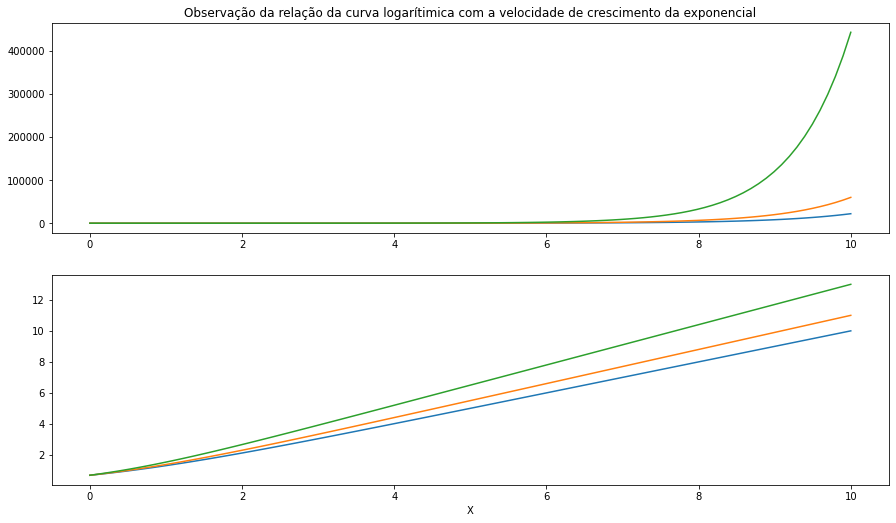

In [180]:
x = np.linspace(start=0, stop=10, num=100)

y1 = np.exp(x)
y2 = np.exp(1.1*x)
y3 = np.exp(1.3*x)

plt.figure(figsize=(15, 8.5))

plt.subplot(211)
plt.title('Observação da relação da curva logarítimica com a velocidade de crescimento da exponencial')
plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y3)

plt.subplot(212)
plt.plot(x, np.log(y1+1))
plt.plot(x, np.log(y2+1))
plt.plot(x, np.log(y3+1))
_=plt.xlabel('X')

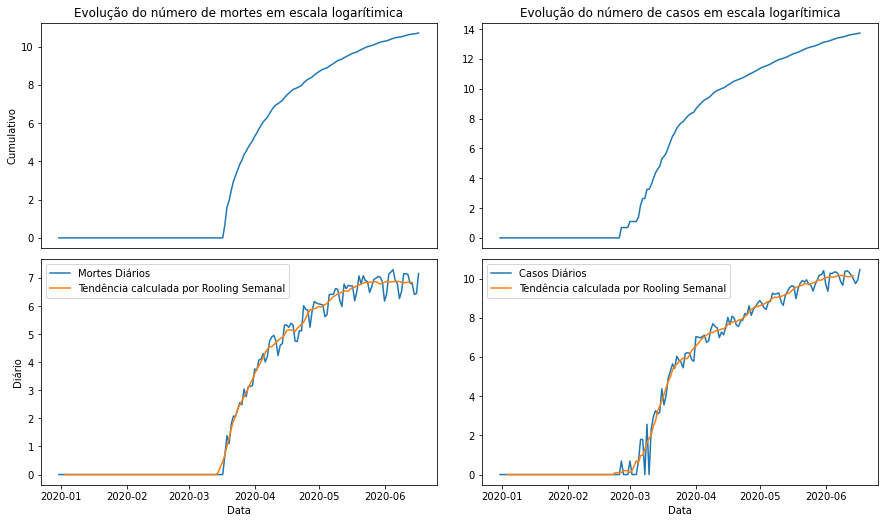

In [181]:
plt.figure(figsize=(15, 8.5))
plt.subplots_adjust(hspace=0.05, wspace=0.115)

plt.subplot(221)
plt.plot(Covid_Activity_Brazil.index, np.log(Covid_Activity_Brazil.PEOPLE_DEATH_COUNT+1))
_=plt.ylabel('Cumulativo')
plt.title('Evolução do número de mortes em escala logarítimica')
plt.xticks([])

plt.subplot(223)
plt.plot(Covid_Activity_Brazil.index, np.log(Covid_Activity_Brazil.PEOPLE_DEATH_NEW_COUNT+1), label='Mortes Diários')
covid_activity_weekly_rooling_log = np.log(Covid_Activity_Brazil['PEOPLE_DEATH_NEW_COUNT']+1).rolling(window = 7, center = True).mean()
plt.plot(covid_activity_weekly_rooling_log, label='Tendência calculada por Rooling Semanal')
plt.legend()
_=plt.ylabel('Diário')
_=plt.xlabel('Data')

plt.subplot(222)
plt.plot(Covid_Activity_Brazil.index, np.log(Covid_Activity_Brazil.PEOPLE_POSITIVE_CASES_COUNT+1))
plt.title('Evolução do número de casos em escala logarítimica')
plt.xticks([])

plt.subplot(224)
plt.plot(Covid_Activity_Brazil.index, np.log(Covid_Activity_Brazil.PEOPLE_POSITIVE_NEW_CASES_COUNT+1), label='Casos Diários')
covid_activity_weekly_rooling_log = np.log(Covid_Activity_Brazil['PEOPLE_POSITIVE_NEW_CASES_COUNT']+1).rolling(window = 7, center = True).mean()
plt.plot(covid_activity_weekly_rooling_log, label='Tendência calculada por Rooling Semanal')
plt.legend()
_=plt.xlabel('Data')

Para modelarmos um possível cenário da pandemia sem as medidas de isolamento, utilizaremos as mesmas hipóteses descritas na seção anterior, porém utilizando os dados até o primeiro dia anterior ao início do isolamento. Assim, utilizaremos os dados até o dia 16 de março, visto que no dia [17 o isolamento começou na maior parte do país](https://exame.com/brasil/periodo-de-isolamento-comeca-a-valer-nesta-terca-no-estado-de-sao-paulo/). Em uma análise mais correta, seriam considerados mais dias, visto que o vírus demora um certo tempo para ter algum efeito, porém como esses dados ainda não estão sendo divulgados com precisão, consideramos apenas até esta data.

### **Número de casos**

#### **Sigmóide**

In [182]:
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

In [183]:
index_X = Covid_Activity_Brazil.loc[(Covid_Activity_Brazil.index < datetime(2020, 3, 17)), :].index
X = np.arange(len(index_X.values))
Y = Covid_Activity_Brazil.loc[index_X, :].PEOPLE_POSITIVE_CASES_COUNT.values

In [184]:
constraints = [[2000000, len(X), 0, -np.inf], [3500000, len(X)+60, 1, np.inf]]
popt, pcov = curve_fit(sigmoid, X, Y, bounds=[popt_sig_cases, np.inf],  maxfev=10000)

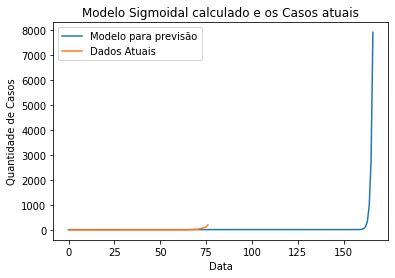

In [185]:
X_new = np.arange(len(X)+90)
plt.plot(X_new, sigmoid(X_new, *popt), label='Modelo para previsão')
plt.plot(X, Y, label='Dados Atuais')
plt.legend()
_=plt.ylabel('Quantidade de Casos')
_=plt.xlabel('Data')
_=plt.title('Modelo Sigmoidal calculado e os Casos atuais')

#### **Tangente Hiperbólico**

In [186]:
def tanh(x, L ,x0, k, b):
    y = L*(np.exp(k*(x-x0))-np.exp(-k*(x-x0)))/ (np.exp(k*(x-x0)) + np.exp(-k*(x-x0)))+b
    return (y)

In [187]:
constraints = [[40000, len(X), 0, 40000], [300000, len(X)+60, 1, 300000]]
popt_tanh_cases, pcov_tanh_cases = curve_fit(tanh, X, Y, bounds=constraints, maxfev=10000)

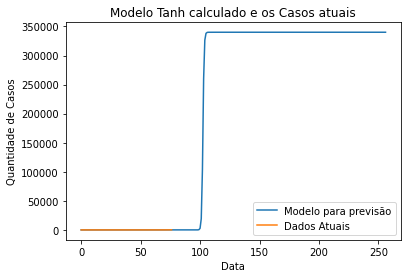

In [188]:
X_new = np.arange(len(X)+180)
plt.plot(X_new, tanh(X_new, *popt_tanh_cases), label='Modelo para previsão')
plt.plot(X, Y, label='Dados Atuais')
plt.legend()
_=plt.ylabel('Quantidade de Casos')
_=plt.xlabel('Data')
_=plt.title('Modelo Tanh calculado e os Casos atuais')

### **Número de Mortes**

Como vimos anteriormente, a primeira morte ocorrida no Brasil aconteceu após o início do isolamento, então não temos dados suficientes realizar essa predição utilizando esses modelos. Assim, para a modelagem desse fenômeno temos que utilizar modelos epidemiológicos.

### **Conclusões acerca das previsões com condições pré-isolamento**

Como vimos anteriormente, as predições para o Brasil dadas as condições pré-isolamento não obtiveram uma acurácia adequada. Isso se deve ao fato de que utilizamos modelos que dependem dos dados para o cálculo dos seus parâmetros. Além disso, a única consideração que fizemos diz respeito apenas a forma da curva. Assim, como a disponibilidade de dados é baixa (ou inexistente como no caso das mortes), não é possível a obtenção dessa previsão por meio da utilização desses modelos.

Entretanto, é possível obter predições dessa natureza por meio de modelos epidemiológicos. [Nesta página](https://www.cdc.gov/coronavirus/2019-ncov/covid-data/forecasting-us.html) desnvolvida pelo CDC (*Centers for Disease Control and Prevention*) podemos encontrar um conjunto de predições feitas por universidades americanas, onde dentre as metodologias utilizadas destaca-se a [SEIR, que é uma variação do modelo SIR](https://towardsdatascience.com/infectious-disease-modelling-beyond-the-basic-sir-model-216369c584c4). A explicação detalhada desses modelos está fora do escopo desse texto, porém em resumo podemos dizer que esses modelos separam a população em compartimentos, neste caso em:
* Suscetíveis a serem infectados;
* Infectados;
* Recuperados;

Assim, utilizando de um conjunto de parâmetros como, grau de contágio, número de dias que o infectado pode espalhar a doença, entre outros, calcula-se as variações diárias entre esses compartimentos das populações e assim modela-se o fenômeno epidemiológico, para uma descrição deste procedimento, favor [ver este artigo](https://towardsdatascience.com/infectious-disease-modelling-part-i-understanding-sir-28d60e29fdfc). 